In [1]:
import torch

import keras
import keras_tuner as kt
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt


# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


Reloading Tuner from ./fashion_mnist03/tuner0.json


/Users/thomasjones/.pyenv/versions/3.10.15/envs/MLExp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/thomasjones/.pyenv/versions/3.10.15/envs/MLExp/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,306 (4.51 MB)

 Trainable params: 1,183,306 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

<Axes: xlabel='optimizer', ylabel='score'>

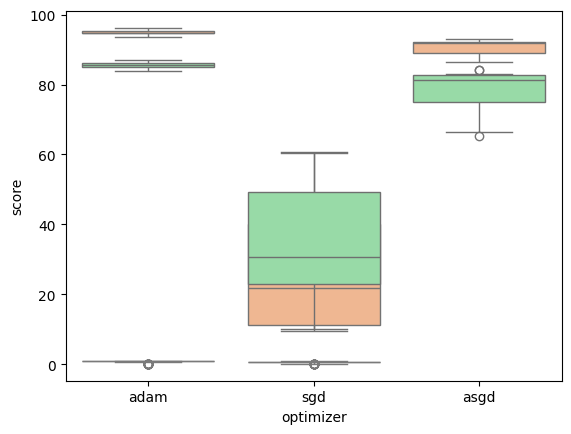

In [7]:

class HyperModelSearch(kt.HyperModel):

    def build(self,hp):
        model = keras.Sequential()

        input_layer_should_have_dropout = hp.Boolean('input_layer_should_have_dropout')
        input_layer_dropout = hp.Float('input_layer_dropout', min_value=0.1, max_value=0.5, step=0.1, parent_name='input_layer_should_have_dropout', parent_values=[True])

        layer_1_filter_count = hp.Int('layer_1_filter_count', min_value=32, max_value=64, step=16)
        layer_1_kernel_size = hp.Int('layer_1_kernel_size', min_value=3, max_value=5, step=1)
        layer_1_activation = hp.Choice('layer_1_activation', values=['relu', 'sigmoid'])
        should_have_layer_1_dropout = hp.Boolean('should_have_layer_1_dropout')
        layer_1_dropout = hp.Float('layer_1_dropout', min_value=0.1, max_value=0.5, step=0.1, parent_name='should_have_layer_1_dropout', parent_values=[True])


        should_have_layer_2 = hp.Boolean('should_have_layer_2')
        layer_2_filter_count = hp.Int('layer_2_filter_count', min_value=64, max_value=128, step=16, parent_name='should_have_layer_2', parent_values=[True])
        layer_2_activation = hp.Choice('layer_2_activation', values=['relu', 'sigmoid'], parent_name='should_have_layer_2', parent_values=[True])
        should_have_layer_2_dropout = hp.Boolean('should_have_layer_2_dropout', parent_name='should_have_layer_2', parent_values=[True])
        layer_2_dropout = hp.Float('layer_2_dropout', min_value=0.1, max_value=0.5, step=0.1, parent_name='should_have_layer_2', parent_values=[True])
        

        dense_layer1_units = hp.Int('dense_layer_units', min_value=32, max_value=256, step=32)
        dense_layer1_activation = hp.Choice('dense_layer_activation', values=['relu', 'sigmoid'])

        should_have_dense_layer2 = hp.Boolean('should_have_dense_layer2')
        dense_layer2_units = hp.Int('dense_layer2_units', min_value=32, max_value=128, step=32, parent_name='should_have_dense_layer2', parent_values=[True])
        dense_layer2_activation = hp.Choice('dense_layer2_activation', values=['relu', 'sigmoid'], parent_name='should_have_dense_layer2', parent_values=[True])

        learning_rate = 0.001

        optizmizer = hp.Choice('optimizer', values=['adam', 'sgd'])

        if optizmizer == 'adam':
            learning_rate = hp.Choice('learning_rate', values=[0.001, 0.002])
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optizmizer == 'sgd':
            learning_rate = hp.Choice('learning_rate', values=[0.01, 0.02])
            momentum = hp.Choice('momentum', values=[0.5, 0.1])
            optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)


        model.add(keras.layers.Input(shape=(28,28,1)))
        if input_layer_should_have_dropout:
            model.add(keras.layers.Dropout(input_layer_dropout))
        model.add(keras.layers.Conv2D(filters=layer_1_filter_count, kernel_size=layer_1_kernel_size, activation=layer_1_activation))
        model.add(keras.layers.MaxPooling2D(pool_size=2))
        if should_have_layer_1_dropout:
            model.add(keras.layers.Dropout(layer_1_dropout))

        if should_have_layer_2:
            model.add(keras.layers.Conv2D(filters=layer_2_filter_count, kernel_size=3, activation=layer_2_activation))
            model.add(keras.layers.MaxPooling2D(pool_size=2))
            if should_have_layer_2_dropout:
                model.add(keras.layers.Dropout(layer_2_dropout))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(dense_layer1_units, activation=dense_layer1_activation))
        if should_have_dense_layer2:
            model.add(keras.layers.Dense(dense_layer2_units, activation=dense_layer2_activation))
        model.add(keras.layers.Dense(10, activation='softmax'))

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args, 
            batch_size=hp.Int('batch_size', min_value=32, max_value=256, step=32),
            epochs=hp.Int('epochs', min_value=10, max_value=30, step=10),
            **kwargs
        )
    


# trials = kt.GridSearch(build_model, objective='val_accuracy', max_trials=5, seed=42)
# trials = kt.BayesianOptimization(build_model, num_initial_points=3, objective='val_accuracy', max_trials=250, project_name='fashion_mnist02')
trials = kt.RandomSearch(HyperModelSearch(), objective='val_accuracy', max_trials=250, project_name='fashion_mnist03', seed=42)

#Uncomment to run search
# trials.search(x_train, y_train, validation_data=(x_test, y_test))

results_dir = './fashion_mnist03'

best_model = trials.get_best_models(num_models=2)[1]

best_model.summary()

res_csv = os.path.join(results_dir, 'results3.csv')

#create the results file

outfile = open(res_csv, 'w')

oracle_data = json.load(open(os.path.join(results_dir, 'oracle.json')))

all_hyperparameters = [str(x['config']['name']) for x in oracle_data['hyperparameters']['space']]


outfile.write(f"{','.join(all_hyperparameters)},score\n")

#iterate through the trial folders in the results directory
for trial in os.listdir(results_dir):
    trial_path = os.path.join(results_dir, trial)
    if os.path.isdir(trial_path):
        trial_json = os.path.join(trial_path, 'trial.json')
        with open(trial_json) as f:
            trial_data = json.load(f)
            model_values = trial_data['hyperparameters']['values']
            #join the keys

            model_str = ''

            for k in all_hyperparameters:
                if k not in model_values:
                    model_str += ','
                else:
                    model_str += str(model_values[k]) + ','

            outfile.write(f"{model_str}{trial_data['score']}\n")

outfile.close()

data_res_cnn = pd.read_csv(res_csv)
data_res_larger_mnist = pd.read_csv('larger_mnist.csv', sep='|')
data_res_larger_fash_mnist = pd.read_csv('larger_fashion_mnist.csv', sep='|')

#plot optimizer selection vs score
#create 3 box plots in one figure, one for each dataset
sns.set_palette('pastel')

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for data_res_cnn
sns.boxplot(x='optimizer', y='score', data=data_res_cnn, ax=axes[0])
axes[0].set_title('CNN Dataset')

# Plot for data_res_larger_mnist
sns.boxplot(x='optimizer', y='score', data=data_res_larger_mnist, ax=axes[1])
axes[1].set_title('Larger MNIST Dataset')

# Plot for data_res_larger_fash_mnist
sns.boxplot(x='optimizer', y='score', data=data_res_larger_fash_mnist, ax=axes[2])
axes[2].set_title('Larger Fashion MNIST Dataset')

# Set a common y-label
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

plt.tight_layout()
plt.show()



